# First look on the initially reduced data for IRDIS
- Correcting for the unresolved
- psf smearing correction (we are saving fits with and without this correction)
-  plotting
- total polarised intensity

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
import functions as f
import scipy.ndimage as ndimage

def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data
            
    return fit

def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout
    plt.grid(False)

In [3]:
def load_tel_corr(dirdat,camera,process):
    dir = dirdat
    files = os.listdir(dir)
    qfile = 'qcorr_'+str(process)+'_'+str(camera)+'.fits'
    ufile = 'ucorr_'+str(process)+'_'+str(camera)+'.fits'
    qphifile = 'qphi_'+str(process)+'_'+str(camera)+'.fits'
    uphifile = 'uphi_'+str(process)+'_'+str(camera)+'.fits'
    
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
        if fnmatch.fnmatch(file, ufile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
        #if fnmatch.fnmatch(file, qphifile):
        #    hdulq = fits.open(dir + file)
        #    q_phi = hdulq[0].data
        #if fnmatch.fnmatch(file, uphifile):
        #    hdulq = fits.open(dir + file)
        #    u_phi = hdulq[0].data    
            
            
    n=q.shape[0]
     #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)
    q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
    # q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-16
    u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)    
    
    return q,u,q_phi,u_phi

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")

def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_FWHM (PSF,n,ps,figfolder,title=None):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    if title!=None:
        plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def Loadimagespsf_AR(star):
    dir = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/classic_reduction/'+star+'/'
 
    psfile =  '*REDUCED_I.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSFv = hdulPSF[0].data[0]
            PSFi = hdulPSF[0].data[1]

            
    return PSFv,PSFi

def load_I(dirdat,process):
    dir = dirdat
    qfile = str(process)+'*'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            #q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            #u = hdulq[0].data[3]
            n=iq.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i

def plot_with_unres_Aolp(image,aolp,dolp,lim,ps):

    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = image.shape[0]
    d = n * ps / 2
        #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)


    im1=i_plot.imshow(np.arcsinh(image),extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical',shrink=0.8)
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    #plt.tight_layout(pad=0.1)     

    # polarization angle
    psi=np.deg2rad(aolp*1.)


    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = dolp*np.cos(psi+np.pi/2) # X-vector 
    pixY = dolp*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(0, 0, pixX, pixY,scale=0.08, **quiveropts)

def calculate_unresolved(correction_radius, q, u,i,ps,R,normlim):
    # Calculates degree and angle of unresolved polarisation
    #resulting values are in fraction (not %) for dolp, and in degrees for aolp
    

    mask=(R<=correction_radius)

    normalisation=np.sum(i[R<=1500/ps])
    q_over_i=np.divide(q,i,where=i!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u,i,where=i!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    aolp_unres=np.rad2deg(0.5*np.arctan2(cu, cq))
    #print(aolp_unres)
    if aolp_unres<0 : 
        aolp_unres=aolp_unres+180
    dolp_unres=np.sum(np.sqrt(cu*i*cu*i+ cq*i*cq*i)*(R<=normlim))/normalisation
    
    q_corr=q-cq*i
    u_corr=u-cu*i
    return dolp_unres, aolp_unres,q_corr,u_corr

def maskcrit(aolp,R):
    phi = (aolp) #ndimage.gaussian_filter(aolp, sigma=(2, 2), order=1)#
    
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>np.pi/2:
                #print(phi[ix,iy])
                phi[ix,iy]=phi[ix,iy]-np.pi/2
            
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]<-np.pi/2:
                
                phi[ix,iy]=phi[ix,iy]+np.pi/2      
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmean(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,Q,U,R,I,Q_PHI,title,save,plot,noise,lim,aolp_plot=False):
    
    n = Q_PHI.shape[0]
    Q=Q[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    U=U[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    R=R[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    I=I[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    Q_PHI=Q_PHI[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    n = Q_PHI.shape[0]
    d = n * ps / 2

    im1=ax.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))
    #plt.xlim(-lim * ps, lim * ps)
    #plt.ylim(-lim * ps, lim * ps)
    fig.colorbar(im1, orientation='vertical',shrink=0.75)

    plt.xlabel('mas',fontsize=14)
    plt.ylabel("mas",fontsize=14)
     
    ax.tick_params(axis='both',labelsize=14)
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = ax.get_xlim()
    yy0, yy1 = ax.get_ylim()

    # binning factor
    factor = [1, 1]

    # re-binned number of points in each axis
    nx_new = Q_PHI.shape[1] // factor[0]
    ny_new = Q_PHI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    #Here you have to recalculate the AoLP (marked as psi) for the binned data. If you try to just bin AoLP it wil mess up angles
    psi=0.5*np.arctan2(U_bin, Q_bin)
    #psi=ndimage.gaussian_filter(psi, sigma=(1, 1), order=0) #smooting by gaussian filter   
            
    # polarization fraction
    frac =Q_phi_bin/I_bin
    
    # mask to show only alighned

    #mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=noise*5
    mask=mask2#*mask1
    
    
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    if aolp_plot:
        pixX = frac*np.cos(psi+np.pi/2) # X-vector 
        pixY = frac*np.sin(psi+np.pi/2) # Y-vector

        # keyword arguments for quiverplots
        quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
        ax.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)

    
    mask=mask.astype(int)
    levels = [0,1]  # Adjust this as needed
    CS = ax.contour(X, Y, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
    #ax.clabel(CS, inline=True, fontsize=10)
    
    plt.title(title,fontsize=16)
    if save!=False:
        plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    if plot!=False:
        plt.show()
    plt.close()
    
def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])

    return psf_sum, q_sum, u_sum

## Correction of the unresolved polarisation within 3 pixel radius, PSF smearing, aperture polarimetry (Q/I and U/I)

In [4]:
# stars=['AR_Pup_dc_notnorm','UMon','HR4049_20190108','HR4049_20190107','V709_Car','HR4226']

irdis_stars=['01.SCI_UMon','u_mon_combined','u_mon_2019-01-03_calib','u_mon_2019-01-14_calib']
irdis_to_zimp={'hr4049':'HR4049_20190108','01.SCI_UMon':'UMon','u_mon_2019-01-03_calib':'UMon','u_mon_2019-01-14_calib':'UMon'}

disk_incl_pa={'AR_Pup':[75,45],'UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
stars_type={'IRAS08544-4431_dc_notnorm':'sci','HD75885':'ref', '01.SCI_AR_Pup':'sci','01.SCI_UMon':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','HD71253':'ref'}
ref_of_sci={'HD75885':'AR_Pup','01.SCI_UMon':'UMon','HD71253':'UMon','HD94680':'V709_Car','HD96314':'HR4049','HD98025':'HR4226'}

star=irdis_stars[0] #which star to process

01.SCI_UMon
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ/I[%]  sumQ_phi/I[%] sumPI/I[%] 
H
telescope corrected            24273.602  197.640    319.512    1.474      0.262      1.570       

01.SCI_UMon
144
25
 +corr for PSF smear           11.416     572.638    564.590    nan        0.430      2.920       



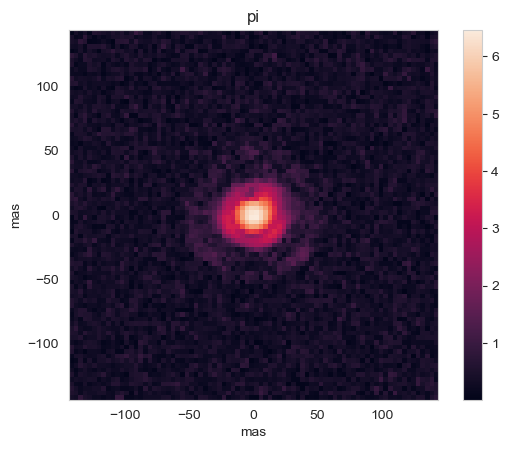

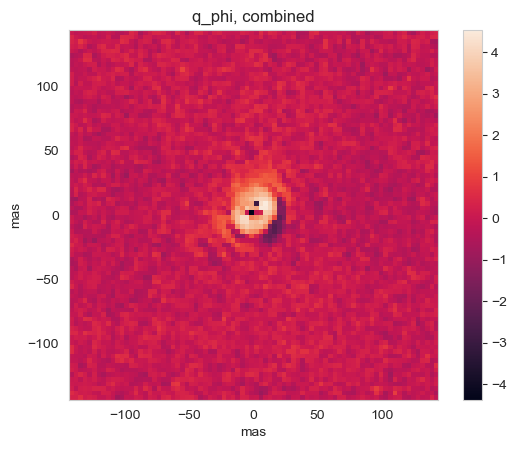

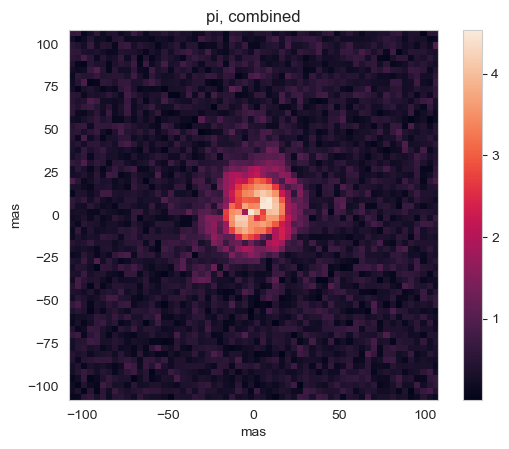

tel+corr for unres             18979.322  63.605     285.621    -0.033     0.241      0.413       

 +corr for PSF smear           19466.724  142.347    285.621    nan        0.605      0.754       

DoLP, % of total I
1.5162411
AoLP
176.92328


In [5]:
print(star)

ps=12.27

figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/IRDIS/'
createfolder(figfolder)

print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} ".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI","sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]"))

normlim=200/ps

print('H')
if star=='01.SCI_UMon':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/IRDIS/2019/2.0/reduced_pdi/no_star_pol_subtr/'
else:
    dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/IRDAP_Reduced/reduced_pdi/no_star_pol_subtr/'

iqfile = '*I_Q.fits'
iufile = '*I_U.fits'
if star=='hr4049':
    qfile = '*29_Q.fits'
    ufile = '*29_U.fits'
elif star=='iras08544-4431_calib':
    qfile = '*25_Q.fits'
    ufile = '*25_U.fits'
elif star=='01.SCI_UMon':
    qfile = '*14_Q.fits'
    ufile = '*14_U.fits'
elif star=='u_mon_2019-01-03_calib':
    qfile = '*03_Q.fits'
    ufile = '*03_U.fits'
elif star=='u_mon_2019-01-14_calib':
    qfile = '*14_Q.fits'
    ufile = '*14_U.fits'
ifile = '*I_tot.fits'
qphifile = '*Q_phi.fits'
uphifile = '*U_phi.fits'
pifile = '*I_pol.fits'

files = os.listdir(dirdat)     
for file in files:
    if fnmatch.fnmatch(file, iqfile):
        hdul = fits.open(dirdat + file)
        iq_mean_comb = hdul['Primary'].data 
    if fnmatch.fnmatch(file, iufile):
        hdul = fits.open(dirdat + file)
        iu_mean_comb = hdul['Primary'].data 
    if fnmatch.fnmatch(file, qfile):
        hdul = fits.open(dirdat + file)
        q_mean_comb = hdul['Primary'].data 
    if fnmatch.fnmatch(file, ufile):
        hdul = fits.open(dirdat + file)
        u_mean_comb = hdul['Primary'].data 
    if fnmatch.fnmatch(file, ifile):
        hdul = fits.open(dirdat + file)
        i_mean_comb = hdul['Primary'].data 
    if fnmatch.fnmatch(file, qphifile):
        hdul = fits.open(dirdat + file)
        q_phi_mean_comb = hdul['Primary'].data
        # q_phi_mean_comb=q_phi_mean_comb*(q_phi_mean_comb>=0)+1e-16*(q_phi_mean_comb<0) # we are looking only on positive q_phi

    if fnmatch.fnmatch(file, uphifile):
        hdul = fits.open(dirdat + file)
        u_phi_mean_comb = hdul['Primary'].data 
    if fnmatch.fnmatch(file, pifile):
        hdul = fits.open(dirdat + file)
        pi_mean_comb = hdul['Primary'].data 

output_filename = figfolder+star+'_'+'H'+'_stats.txt'

with open(output_filename, 'w') as file_print:
    file_print.write("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI","sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]"))

    n=q_mean_comb.shape[0]
            #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)

    if star=='AR_Pup' or star=='AR_Pup_dc_notnorm':
        lim=100       
    else:
        lim=20

    # Initial aperture calculations for the mean_combined data and writing to the file
    frac=np.max(np.divide(q_phi_mean_comb,i_mean_comb,where=i_mean_comb!=0)*(R<=50)*(R>1))*100

    mask=(R<=normlim)
    q_sum=np.sum(q_mean_comb[mask])
    qphi_sum=np.sum(q_phi_mean_comb[mask])
    I_sum=np.sum(i_mean_comb[R<=1500/ps])
    pi_sum=np.sum(pi_mean_comb[mask])

    fwhm=find_FWHM(i_mean_comb,n,ps,figfolder,'H'+'_gauss_mean_combined')

    # calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
    normalisation=np.sum(i_mean_comb[R<=1500/ps])
    peak_i=np.max(i_mean_comb*(R<normlim))/normalisation
    peak_pi=np.max(pi_mean_comb*(R<normlim))/normalisation
    peak_q_phi=np.max(q_phi_mean_comb*(R<normlim))/normalisation # might be less informative than PI because of unresolved signal in the center

    line = "{:<30} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('telescope corrected',
        frac, np.max(q_phi_mean_comb), np.max(pi_mean_comb), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
    print(line)
    file_print.write(line)

    filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}

    for fileindex,image1 in enumerate([pi_mean_comb,q_phi_mean_comb, u_phi_mean_comb,q_mean_comb,u_mean_comb,i_mean_comb]):
        out_fits = fits.HDUList(fits.PrimaryHDU(image1))                  # create output fits structure
        out_fits.writeto(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_meancombined.fits', overwrite = True)                       # write output

        image_an = image1*(R<normlim)
        image=np.arcsinh(image_an)
        fig, ax = plt.subplots()
        f.plottingroutinemas(image,lim,ps,n,star,ax)        
        f.scale_mas(star,ax)  

        plt.title(star+', '+filename[fileindex]+', '+'H'+', mean combined') 
        plt.savefig(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_'+'_meancombined.jpeg',bbox_inches='tight', pad_inches=0.1)
        #plt.show()
        plt.close()

    mask=(R<=normlim)

    star_zimp=irdis_to_zimp[star]
    incl_pa=disk_incl_pa[star_zimp]

    print(star)
    
    if stars_type[star]=='sci' and star_zimp!='AR_Pup_dc_notnorm':
        print(str(incl_pa[1]))
        print(str(incl_pa[0]))
        f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_models/',star+'H'+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
        f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_models/',star+'H'+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')

    # correct for smearing
    q_phi_smearing=q_phi_mean_comb*f_q
    pi_smearing=pi_mean_comb*f_pi

    qphi_smearing_sum=np.sum(q_phi_smearing[mask])
    pi_smearing_sum=np.sum(pi_smearing[mask])

    peak_pi_smearing=np.max(pi_smearing*(R<normlim))/normalisation
    peak_q_phi_smearing=np.max(q_phi_smearing*(R<normlim))/normalisation #migh be less informative than PI because of unresolved signal in the center
    frac_smearing =np.max(np.divide(q_phi_smearing,i_mean_comb,where=i_mean_comb!=0)*(R<=normlim)*(R>1))*100

    line = "{:<30} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format(' +corr for PSF smear',
        frac_smearing, np.max(q_phi_smearing), np.max(pi_smearing), np.nan, qphi_smearing_sum/I_sum*100, pi_smearing_sum/I_sum*100)
    print(line)

    file_print.write(line) 

    # correction for unresolved polarisation
    correction_radius=3
    dolp_unres,aolp_unres,q_corr,u_corr=calculate_unresolved(correction_radius, q_mean_comb, u_mean_comb,i_mean_comb,ps,R,normlim)

    q_corr2,u_corr2=q_corr,u_corr

    q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
    # q_phi_corr = (q_phi_corr> 0)*q_phi_corr +  (q_phi_corr <=0 )*1e-16
    u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
    pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
    aolp_corr=0.5*np.arctan2(u_corr, q_corr)

    # pi_mean_comb = np.rot270(pi_mean_comb)
    # q_phi_corr = np.rot270(q_phi_corr)
    # pi_corr = np.rot270(pi_corr)

    
    plotImage(pi_mean_comb,40)
    plt.title('pi')
    plt.show()
    plt.close()

    plotImage(q_phi_corr,40)
    plt.title('q_phi, combined')
    plt.show()
    plt.close()
    
    plotImage(pi_corr,30)
    plt.title('pi, combined')
    plt.show()
    plt.close()

    dolp_corr=np.divide(q_phi_corr,i_mean_comb,where=i_mean_comb!=0)*(R<=50)#*(R>1)


    frac =np.max(dolp_corr)*100

    mask=(R<=normlim)
    q_sum=np.sum(q_corr[mask])
    qphi_sum=np.sum(q_phi_corr[mask])
    pi_sum=np.sum(pi_corr[mask])

    q_phi_corr_smearing=q_phi_corr*f_q
    pi_corr_smearing=pi_corr*f_pi

    dolp_corr_smearing=np.divide(q_phi_corr_smearing,i_mean_comb,where=i_mean_comb!=0)*(R<=50)#*(R>1)

    #plotImage(dolp_corr_smearing,50)
    #plt.show()
    #plt.close()
    #plotImage(q_phi_corr_smearing,50)
    #plt.show()
    #plt.close()
    qphi_corr_smearing_sum=np.sum(q_phi_corr_smearing[mask])
    pi_corr_smearing_sum=np.sum(pi_corr_smearing[mask])

    line = "{:<30} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format('tel+corr for unres',
        frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
    print(line)   
    file_print.write(line) 

    frac_corr_smearing =np.max(dolp_corr_smearing)*100

    line = "{:<30} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format(' +corr for PSF smear',
        frac_corr_smearing, np.max(q_phi_corr_smearing), np.max(pi_corr_smearing), np.nan, qphi_corr_smearing_sum/I_sum*100, pi_corr_smearing_sum/I_sum*100)
    print(line)
    file_print.write(line)

    filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr',3:'Q_phi_corr_smearing',4:'PI_corr_smearing'}


    for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr,q_phi_corr_smearing,pi_corr_smearing]):
        # print(image1)
        out_fits = fits.HDUList(fits.PrimaryHDU(image1))
        # print(fileindex)# create output fits structure
        if fileindex<3:
            out_fits.writeto(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_tel+unres.fits', overwrite = True)
            # print("Less than 4:" , filename[fileindex])# write output
        if fileindex>=3:
            # print("Greater than 4: ", filename[fileindex])
            # print()
            out_fits.writeto(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_tel+unres+PSF_smear.fits', overwrite = True)                       # write output

        image_an = image1*(R<normlim)
        image=np.arcsinh(image_an)
        fig, ax = plt.subplots()
        f.plottingroutinemas(image,lim,ps,n,star,ax)        
        f.scale_mas(star,ax)  
        if fileindex<4:
            plt.title(star+', '+filename[fileindex]+', '+'H'+', tel+unres') 
            plt.savefig(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_tel+unres.jpeg',bbox_inches='tight', pad_inches=0.1)

        if fileindex>=4:
            plt.title(star+', '+filename[fileindex]+', '+'H'+', tel+unres+PSF') 
            plt.savefig(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_tel+unres+PSF.jpeg',bbox_inches='tight', pad_inches=0.1)
        #plt.show()
        plt.close()

print('DoLP, % of total I')
print(dolp_unres*100)    
print('AoLP')
print(aolp_unres)


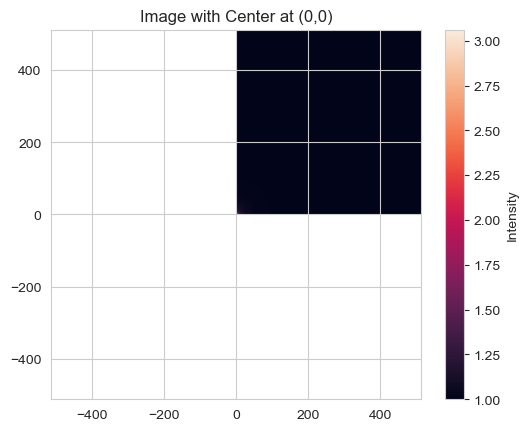

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Example image array (this would be your actual image data)
image = f_q

# Find the center of the image
n = image.shape[0]
center_x, center_y = n // 2, n // 2  # For a square image

# Translate the image so that the center becomes (0,0) in the new coordinate system
shifted_image = np.roll(image, shift=-center_x, axis=0)  # Shift along the x-axis
shifted_image = np.roll(shifted_image, shift=-center_y, axis=1)  # Shift along the y-axis

# Create new coordinate grid (in pixel coordinates)
x = np.linspace(-center_x, center_x, n)  # x coordinates centered at 0
y = np.linspace(-center_y, center_y, n)  # y coordinates centered at 0
X, Y = np.meshgrid(x, y)

# Plot the shifted image
plt.imshow(shifted_image)  # 'lower' places (0,0) at the bottom-left
plt.xlim(-center_x, center_x)
plt.ylim(-center_y, center_y)
plt.title("Image with Center at (0,0)")
plt.colorbar(label="Intensity")
plt.show()


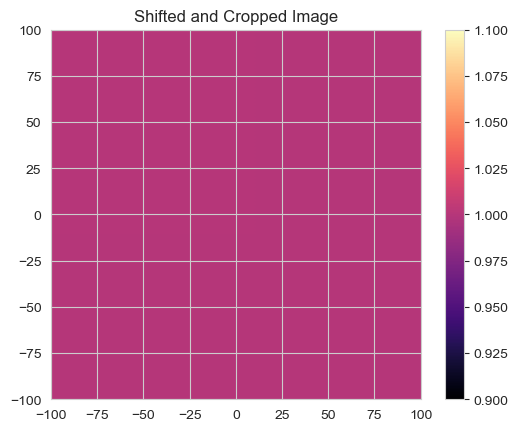

In [7]:
from scipy.ndimage import shift

image = f_q


# Get image dimensions
image_shape = image.shape
original_center = (image_shape[0] // 2, image_shape[1] // 2)
desired_center = (0, 0)

# Compute the shift needed to move the center to (0,0)
shift_y = -original_center[0]  # Move to (0,0)
shift_x = -original_center[1]

# Apply the shift
shifted_image = shift(image, shift=(shift_y, shift_x), mode='nearest')

# Define crop boundaries
y_min, y_max = original_center[0] - 100, original_center[0] + 100
x_min, x_max = original_center[1] - 100, original_center[1] + 100

# Ensure boundaries are within image limits
y_min, y_max = max(0, y_min), min(image_shape[0], y_max)
x_min, x_max = max(0, x_min), min(image_shape[1], x_max)

# Crop the image
shifted_image_cropped = shifted_image[y_min:y_max, x_min:x_max]

# Plot the result
plt.imshow(shifted_image_cropped, cmap='magma', extent=[-100, 100, -100, 100])
plt.colorbar()
plt.title("Shifted and Cropped Image")
plt.show()



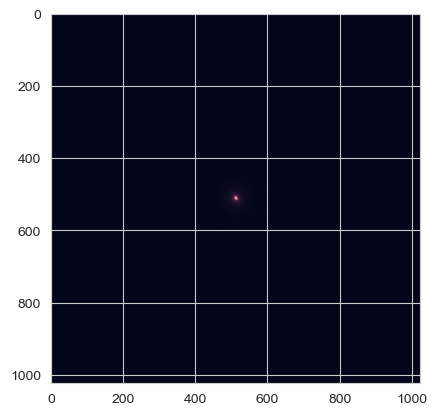

In [8]:
plt.imshow(f_q)

In [9]:
pi_corr_smearing

array([[0.00368852, 0.00368852, 0.00368852, ..., 0.00368852, 0.00368852,
        0.00368852],
       [0.00368852, 0.00368852, 0.00368852, ..., 0.00368852, 0.00368852,
        0.00368852],
       [0.00368852, 0.00368852, 0.00368852, ..., 0.00368852, 0.00368852,
        0.00368852],
       ...,
       [0.00368852, 0.00368852, 0.00368852, ..., 0.00368852, 0.00368852,
        0.00368852],
       [0.00368852, 0.00368852, 0.00368852, ..., 0.00368852, 0.00368852,
        0.00368852],
       [0.00368852, 0.00368852, 0.00368852, ..., 0.00368852, 0.00368852,
        0.00368852]], shape=(1024, 1024))

In [10]:
# out_fits.writeto(figfolder+star+'_'+'H'+'_'+filename[5]+'_tel+unres+PSF_smear.fits', overwrite = True)

In [11]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Unres+PSFcorr/IRDIS/'

## Same for the already corrected for unresolved polarisation component by IRDAP

In [12]:
def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    return dirname

In [13]:
IRDIS=True

01.SCI_UMon
reference            max_DoLP[%] max_Q_phi  max_PI     Peak_I(Strehl)Peak_PI    Peak_Qphi  sumQ/I[%]  sumQ_phi/I[%] sumPI/I[%] 

H
telescope corrected  4.319      66.823     453.438    0.039242  0.000074   0.000066   -0.012     0.175      0.341      

UMon
 +corr for PSF smear 6.139      139.004    453.438    0.039242  0.000184   0.000201   nan        0.420      0.599       



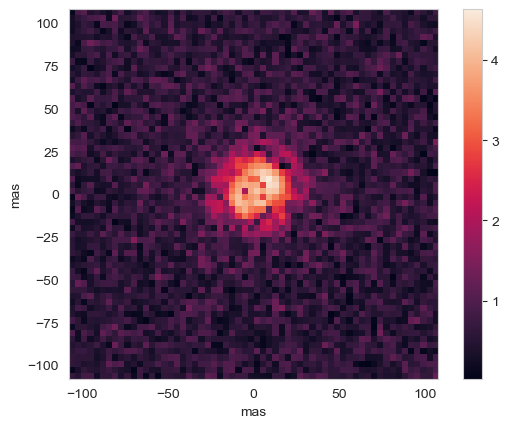

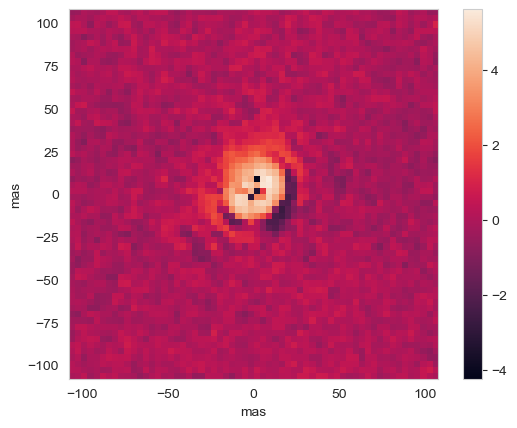

In [14]:
if IRDIS==True:
    irdis_stars=['01.SCI_UMon']
    # irdis_stars=['hr4049','01.SCI_UMon','u_mon_2019-01-03_calib','u_mon_2019-01-14_calib']
    irdis_to_zimp={'hr4049':'HR4049_20190108','01.SCI_UMon':'UMon','u_mon_2019-01-03_calib':'UMon','u_mon_2019-01-14_calib':'UMon'}
    #star='iras08544-4431_calib'
    ps=12.27
    for star in irdis_stars:
        print(star)
        figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/IRDIS/'
        create_dir(figfolder)

        print("{:<20} {:<10} {:<10} {:<10} {:<10}{:<10} {:<10} {:<10} {:<10} {:<10} \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", 'Peak_I(Strehl)','Peak_PI','Peak_Qphi',"sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]"))

        normlim=200/ps

        print('H')
        if star=='01.SCI_UMon':
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/IRDAP_Reduced/reduced_pdi/star_pol_subtr/'
        else:
            dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/IRDAP_Reduced/reduced_pdi/star_pol_subtr/'

        iqfile = '*I_Q*'
        iufile = '*I_U*'
        if star=='hr4049':
            qfile = '*29_Q_star*'
            ufile = '*29_U_star*'
        elif star=='iras08544-4431_calib':
            qfile = '*25_Q_star*'
            ufile = '*25_U_star*'
        elif star=='u_mon_combined':
            qfile = '*14_Q_star*'
            ufile = '*14_U_star*'
        elif star=='u_mon_2019-01-03_calib':
            qfile = '*03_Q_star*'
            ufile = '*03_U_star*'
        elif star=='u_mon_2019-01-14_calib':
            qfile = '*14_Q_star*'
            ufile = '*14_U_star*'
        elif star=='01.SCI_UMon':
            qfile = '*Q_star*'
            ufile = '*U_star*'

        ifile = '*I_tot*'
        qphifile = '*Q_phi*'
        uphifile = '*U_phi*'
        pifile = '*I_pol*'

        files = os.listdir(dirdat)
        for file in files:
            if fnmatch.fnmatch(file, iqfile):
                hdul = fits.open(dirdat + file)
                iq_mean_comb = hdul['Primary'].data

            if fnmatch.fnmatch(file, iufile):
                hdul = fits.open(dirdat + file)
                iu_mean_comb = hdul['Primary'].data

            if fnmatch.fnmatch(file, qfile):
                hdul = fits.open(dirdat + file)
                q_mean_comb = hdul['Primary'].data

            if fnmatch.fnmatch(file, ufile):
                hdul = fits.open(dirdat + file)
                u_mean_comb = hdul['Primary'].data

            if fnmatch.fnmatch(file, ifile):
                hdul = fits.open(dirdat + file)
                i_mean_comb = hdul['Primary'].data

            if fnmatch.fnmatch(file, qphifile):
                hdul = fits.open(dirdat + file)
                q_phi_mean_comb = hdul['Primary'].data
                # q_phi_mean_comb=q_phi_mean_comb*(q_phi_mean_comb>=0)+1e-16*(q_phi_mean_comb<0) #we are lookinf only on positive q_phi

            if fnmatch.fnmatch(file, uphifile):
                hdul = fits.open(dirdat + file)
                u_phi_mean_comb = hdul['Primary'].data
            if fnmatch.fnmatch(file, pifile):
                hdul = fits.open(dirdat + file)
                pi_mean_comb = hdul['Primary'].data



        output_filename = figfolder+star+'_'+'H'+'_IRDAP_stats.txt'

        with open(output_filename, 'w') as file_print:

            n=q_mean_comb.shape[0]
                 #Creating grid
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)

            lim=20

            frac=np.max(np.divide(q_phi_mean_comb,i_mean_comb,where=i_mean_comb!=0)*(R<=normlim)*(R>1))*100

            mask=(R<=normlim)
            q_sum=np.sum(q_mean_comb[mask])
            qphi_sum=np.sum(q_phi_mean_comb[mask])
            I_sum=np.sum(i_mean_comb[R<=1500/ps])
            pi_sum=np.sum(pi_mean_comb[mask])

            fwhm=find_FWHM (i_mean_comb,n,ps,figfolder,'H'+'_gauss_mean_combined')
            # normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.

            # calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
            normalisation=np.sum(i_mean_comb[R<=1500/ps])
            peak_i=np.max(i_mean_comb*(R<normlim))/normalisation
            peak_pi=np.max(pi_mean_comb*(R<normlim))/normalisation
            peak_q_phi=np.max(q_phi_mean_comb*(R<normlim))/normalisation # might be less informative than PI because of unresolved signal in the center

            line = "{:<20} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.6f}{:<10.6f} {:<10.6f} {:<10.3f} {:<10.3f} {:<10.3f} \n".format('telescope corrected',
                frac, np.max(q_phi_mean_comb), np.max(pi_mean_comb),peak_i,peak_pi,peak_q_phi, q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
            print(line)
            file_print.write(line)

            filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}

            for fileindex,image1 in enumerate([pi_mean_comb,q_phi_mean_comb, u_phi_mean_comb,q_mean_comb,u_mean_comb,i_mean_comb]):
                out_fits = fits.HDUList(fits.PrimaryHDU(image1))                  # create output fits structure
                out_fits.writeto(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_meancombined.fits', overwrite = True)                       # write output

                image_an = image1*(R<250)
                image=np.arcsinh(image_an)
                fig, ax = plt.subplots()
                f.plottingroutinemas(image,lim,ps,n,star,ax)
                f.scale_mas(star,ax)

                plt.title(star+', '+filename[fileindex]+', '+'H'+', mean combined')
                plt.savefig(figfolder+star+'_'+'H'+'_'+filename[fileindex]+'_'+'_meancombined.jpeg',bbox_inches='tight', pad_inches=0.1)
                #plt.show()
                plt.close()

            mask=(R<=normlim)

            #f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper2/PSF_models/HD83878/','Hband_qphi_circular_f_psf_50.fits')
            #f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper2/PSF_models/HD83878/','Hband_pi_circular_f_psf_50.fits')
            star_zimp=irdis_to_zimp[star]
            incl_pa=disk_incl_pa[star_zimp]

            print(star_zimp)

            f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_models/',star+'H'+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
            f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_models/',star+'H'+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
            q_phi_smearing=q_phi_mean_comb*f_q
            pi_smearing=pi_mean_comb*f_pi

            qphi_smearing_sum=np.sum(q_phi_smearing[mask])
            pi_smearing_sum=np.sum(pi_smearing[mask])

            peak_pi_smearing=np.max(pi_smearing*(R<normlim))/normalisation
            peak_q_phi_smearing=np.max(q_phi_smearing*(R<normlim))/normalisation #migh be less informative than PI because of unresolved signal in the center
            frac_smearing =np.max(np.divide(q_phi_smearing,i_mean_comb,where=i_mean_comb!=0)*(R<=normlim)*(R>1))*100

            line = "{:<20} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.6f}{:<10.6f} {:<10.6f} {:<10.3f} {:<10.3f} {:<10.3f}  \n".format(' +corr for PSF smear',
                frac_smearing, np.max(q_phi_smearing), np.max(pi_smearing),peak_i,peak_pi_smearing,peak_q_phi_smearing, np.nan, qphi_smearing_sum/I_sum*100, pi_smearing_sum/I_sum*100)
            print(line)

            file_print.write(line)

            dolp_corr=np.divide(q_phi_smearing,i_mean_comb,where=i_mean_comb!=0)*(R<=50)*(R>1)
            plotImage(pi_mean_comb,30)
            plt.grid(False)
            plt.show()
            plt.close()
            plotImage(q_phi_smearing,30)
            plt.show()
            plt.close()

In [15]:
output_filename

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Unres+PSFcorr/IRDIS/01.SCI_UMon_H_IRDAP_stats.txt'

## Calculating Crosstalk